In [483]:
import os
import json
import numpy as np
import csv
import math
import random
import glob
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# import clip
from transformers import CLIPProcessor, CLIPModel,CLIPTokenizer,CLIPImageProcessor,CLIPTextModelWithProjection,CLIPVisionModel

from PIL import Image
from rank_bm25 import BM25Okapi
from nltk.tokenize import RegexpTokenizer
from tqdm import tqdm

from astropy.coordinates import SkyCoord
import astropy.units as u

from Metrics import ndcg_score, map_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)



cuda


In [128]:
docs = []
doc_ids = []
doc_mapping = {}
# with open('./small_dataset.jsonl','r') as f:
with open('./data/dataset.jsonl','r') as f:
    for i, line in tqdm(enumerate(f)):
        line=json.loads(line)
        combined_doc = line['ids']
        for article in line['docs']:
            combined_doc.append(article[1]+article[2]) #article should be in form [doi,title,abstract or full text]
        doc_mapping[int(line['object_number'])] = {
            "object_main_id":line['object_main_id'],
            "ra":line['ra'],
            "dec":line['dec'],
            "mag":line['mag'],
            # "o_type":line['o_type'],
            "ids": line['ids'],
            "docs": line['docs']
        }
        docs.append(' '.join(combined_doc))
        doc_ids.append(int(line['object_number']))

12972it [00:00, 13619.22it/s]


In [129]:
#trying to save just the file rather than whole image
for file in tqdm(glob.glob('./data/images/*')):
    object_number=int(file.split('\\')[1].split('.')[0])
    # image = Image.open(file)
    if object_number in doc_mapping:
        doc_mapping[object_number]['image']=file#np.array(image)

100%|██████████| 12972/12972 [00:00<00:00, 1449617.98it/s]


* ksi UMa


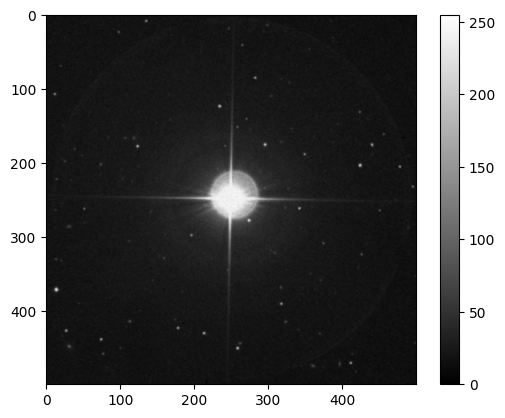

In [144]:
# print(docs[0])
# print(doc_ids[0])
print(doc_mapping[6862]['object_main_id'])
def show_image(image):
    plt.figure()
    plt.imshow(image, cmap='gray')
    plt.colorbar()

    plt.show()
show_image(Image.open(doc_mapping[6862]['image']))

In [438]:
def reg_tokenize_docs(docs,tokenizer = RegexpTokenizer('\\w+')):
  tokenized =[]
  # tokenizer = RegexpTokenizer('\\w+')
  for doc in docs:
    tokens = tokenizer.tokenize(doc)
    tokens = [token.lower() for token in tokens]
    tokenized.append(tokens)
  return tokenized

In [439]:
def get_top_n_docs_for_query(query,scorer,tokenizer=RegexpTokenizer('\\w+'),n=50):
    query=query.lower()
    tokenized_query=tokenizer.tokenize(query)
    scores = scorer.get_scores(tokenized_query)
    result = sorted(zip(doc_ids, scores), key=lambda x: x[1], reverse=True)
    return result[:n]

In [342]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
text_model=CLIPTextModelWithProjection.from_pretrained("openai/clip-vit-base-patch32")
vision_model=CLIPVisionModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
image_proccesser=CLIPImageProcessor.from_pretrained("openai/clip-vit-base-patch32")
text_proccesser=CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")
# transformer = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32").eval()

In [243]:
text_test = ''.join([doc[1]for doc in doc_mapping[0]['docs']])
print(text_test[:77])
tokens = dict(text_proccesser(text_test,return_tensors="pt"))
print(tokens.keys())
image_embedding = image_proccesser(images=[Image.open(doc_mapping[i]['image']).convert("RGB") for i in range(10)],return_tensors="pt")
print(image_embedding.keys())
print(model(**tokens,**image_embedding).logits_per_text)

# print(processor(text=text_test, images=[], return_tensors="pt", padding=True))

Final design and on-sky testing of the iLocater SX acquisition camera: broad-
dict_keys(['input_ids', 'attention_mask'])
dict_keys(['pixel_values'])
tensor([[27.4898, 28.4300, 23.0942, 27.3392, 28.1392, 26.9728, 26.9442, 27.6643,
         27.5260, 26.2147]], grad_fn=<MulBackward0>)


In [281]:
#generate encoding file
import pickle
encoding_directory = './data/encodings/'

for object_number in tqdm(doc_mapping):
    file_name = encoding_directory+str(object_number)+'.data'
    with open(file_name,'wb') as encoding_file:
        image=Image.open(doc_mapping[object_number]['image']).convert("RGB")
        titles=''.join([doc[1]for doc in doc_mapping[object_number]['docs']])
        tokens=text_proccesser(titles)
        line = {
            # 'object_number':object_number,
            'image_encodings':image_proccesser(image), #image encodings
            'text_encodings':tokens,    #text encodings            
        }
        pickle.dump(line,encoding_file)
        image.close()
        


100%|██████████| 12972/12972 [04:29<00:00, 48.19it/s]


tensor([[[[-1.5003, -1.5003, -1.5149,  ..., -1.2521, -1.1061, -1.3251],
          [-1.4565, -1.5003, -1.5295,  ..., -0.9456, -0.8434, -1.3397],
          [-1.4857, -1.4857, -1.4711,  ..., -1.3105, -1.3105, -1.3981],
          ...,
          [-1.4857, -1.4127, -1.2959,  ...,  1.4632,  1.3026,  0.2953],
          [-1.4857, -1.4273, -1.3397,  ...,  0.0617, -0.1280, -0.8726],
          [-1.4419, -1.5003, -1.4419,  ..., -0.7412, -0.8434, -1.2229]],

         [[-1.4519, -1.4519, -1.4669,  ..., -1.1968, -1.0467, -1.2718],
          [-1.4069, -1.4519, -1.4820,  ..., -0.8816, -0.7766, -1.2869],
          [-1.4369, -1.4369, -1.4219,  ..., -1.2568, -1.2568, -1.3469],
          ...,
          [-1.4369, -1.3619, -1.2418,  ...,  1.5946,  1.4295,  0.3940],
          [-1.4369, -1.3769, -1.2869,  ...,  0.1539, -0.0412, -0.8066],
          [-1.3919, -1.4519, -1.3919,  ..., -0.6715, -0.7766, -1.1668]],

         [[-1.1958, -1.1958, -1.2100,  ..., -0.9541, -0.8119, -1.0252],
          [-1.1532, -1.1958, -

In [283]:
for object_number in tqdm(doc_mapping):
    file_name = encoding_directory+str(object_number)+'.data'
    with open(file_name,'rb') as encoding_file:
        encodings=pickle.load(encoding_file)
        #print(torch.tensor(encodings['image_encodings']['pixel_values']))

100%|██████████| 12972/12972 [01:04<00:00, 199.64it/s]


In [288]:
inputs = processor(text=["where is the andromeda galaxy"], images=Image.open(doc_mapping[0]['image']).convert("RGB"), return_tensors="pt", padding=True) #12517 #img[1] for img in image_list]
outputs=model(**inputs)

In [289]:
# res,ind=torch.topk(outputs.logits_per_text.softmax(dim=1),5)
# print(ind)
# print(res)
print(inputs['input_ids'])

tensor([[49406,  1234,   533,   518, 42942,  6545, 49407]])


Optional Retraining if needed

In [73]:
# class image_doc_dataset():
#     '''https://www.labellerr.com/blog/fine-tuning-clip-on-custom-dataset/'''
#     def __init__(self, list_image_path,list_docs):
#         self.list_image_path=list_image_path
#         self.list_docs=list_docs

#     def __len__(self):
#         return len(self.list_image_path)

#     def __getitem__(self, idx):
#         # Preprocess image using CLIP's preprocessing function
#         inputs = processor(text = self.doc[idx],images=Image.open(self.list_image_path[idx]))
#         return inputs
#         # image = processor(Image.open(self.list_image_path[idx]))
#         # doc = self.doc[idx]
#         # return image, doc

In [74]:
# list_image_path=[]
# list_docs=[]
# for object_number in doc_mapping:
#     # print(doc_mapping[object_number].keys())
#     if 'image' in doc_mapping[object_number]:
#         list_image_path.append(doc_mapping[object_number]['image'])

#         list_docs.append(doc_mapping[object_number]['docs'])


# train_samples=3000
# train_images = list_image_path[:train_samples]
# train_docs = list_docs[:train_samples]

# test_images = list_image_path[train_samples:]
# test_docs = list_docs[train_samples:]


# train_dataset = image_doc_dataset(train_images,train_docs)
# train_dataloader = DataLoader(train_dataset, batch_size=100, shuffle=True)
# test_dataset = image_doc_dataset(test_images,test_docs)
# tes_dataloader = DataLoader(test_dataset, batch_size=100, shuffle=True)

In [ ]:
# optimizer = torch.optim.Adam(model.parameters(), lr=5e-5,betas=(0.9,0.98),eps=1e-6,weight_decay=0.2)
# loss_img = nn.CrossEntropyLoss()
# loss_txt = nn.CrossEntropyLoss()

# num_epochs = 3
# for epoch in range(num_epochs):
#     pbar = tqdm(train_dataloader, total=len(train_dataloader))
#     for batch in pbar:
#         optimizer.zero_grad()

#         # images,texts = batch 
#         inputs = batch 
        
#         # images= images.to(device)
#         # texts = texts.to(device)

#         # Forward pass
#         # logits_per_image, logits_per_text = model(images, texts)
#         outputs = model(**inputs)

#         # Compute loss
#         ground_truth = torch.arange(len(inputs),dtype=torch.long,device=device)
#         total_loss = (loss_img(outputs.logits_per_image,ground_truth) + loss_txt(outputs.logits_per_text,ground_truth))/2

#         # Backward pass
#         total_loss.backward()
#         optimizer.step()
#         # if device == "cpu":
#         #     optimizer.step()
#         # else : 
#         #     convert_models_to_fp32(model)
#         #     optimizer.step()
#         #     clip.model.convert_weights(model)

#         pbar.set_description(f"Epoch {epoch}/{num_epochs}, Loss: {total_loss.item():.4f}")

In [435]:
def score_clip(query,model,possible_objects,mode='text',encoding_directory='./data/encodings/'):
    query_tokens = text_proccesser(query,return_tensors="pt")
    #query_embedding = text_model(**query_tokens).text_embeds.detach()
    scores=[]
    for object_number in tqdm(possible_objects):
        file_name = encoding_directory+str(object_number)+'.data'
        with open(file_name,'rb') as encoding_file:
            encodings=pickle.load(encoding_file)
        # input_ids=torch.tensor([encodings['text_encodings']['input_ids'][:77]])
        # attention_mask=torch.tensor([encodings['text_encodings']['attention_mask'][:77]])
        pixel_values=torch.tensor(encodings['image_encodings']['pixel_values'])
        image_logits=model(**query_tokens,pixel_values=pixel_values).logits_per_text[0].detach()
        # text_embedding = text_model(input_ids,attention_mask).text_embeds.detach()
        # text_logits = torch.matmul(query_embedding,text_embedding.T)[0]

        logits = image_logits#+0.1*text_logits
        scores.append((object_number,logits.item()))
    return scores


In [ ]:
score_clip('blurry image',model,range(0,100))

In [440]:
tokenized=reg_tokenize_docs(docs)
bm25 = BM25Okapi(tokenized)

In [443]:
# print(get_top_n_docs_for_query("Andromeda",bm25,n=5))
print(get_top_n_docs_for_query("The andromeda galaxy",bm25,n=5))

[(6193, 16.29700757837191), (6213, 14.920472823666932), (10967, 14.62179487946089), (8120, 14.096368044711303), (281, 13.703726953901647)]


In [550]:
def get_bm25_scores(query):
    tokens=query.lower()
    tokenizer=RegexpTokenizer('\\w+')
    tokenized_query=tokenizer.tokenize(tokens)
    scores = bm25.get_scores(tokenized_query)
    return{key:score for key,score in zip(doc_ids, scores)}



def novel_score_method(query,possible_objects):
    scores = []
    bm25_scores=get_bm25_scores(query)
    # print(bm25_scores)
    clip_scores = {key:score for key,score in score_clip(query,model,possible_objects)}
    for object in possible_objects:
        bm25_score=bm25_scores[object]
        clip_score=clip_scores[object]
        magnitude_score = doc_mapping[object]['mag']
        # print('scores::')
        # print(bm25_score)
        # print(clip_score)
        # print(magnitude_score)
        total_score=bm25_score+0.3*clip_score-0.5*magnitude_score
        scores.append((object,total_score))
    return scores
# novel_score_method("galaxy",[0,1,2,3])

In [523]:
relevance_dict={}
with open("queries_test.csv",'r') as f:
    reader=csv.reader(f)
    for i, line in tqdm(enumerate(reader)):
        if i==0:
            continue
        query,object_id,relevance=line
        if query not in relevance_dict:
            relevance_dict[query]={'score_list':[],'object_list':[]}
        relevance_dict[query]['score_list'].append(int(relevance))
        relevance_dict[query]['object_list'].append(int(object_id))
        relevance_dict[query][int(object_id)]=int(relevance)

201it [00:00, 201446.86it/s]


In [551]:
#generate bm25 and random listings

def get_binary_list(list):
    return [0 if i <4 else 1 for i in list]

bm25_map=[]
bm25_ndcg=[]

random_map=[]
random_ndcg=[]


novel_map=[]
novel_ndcg=[]

#hardcoded for a single query = 
# score_list =[5,4,3,1,3,1,2,4,2,1,3,3,2,1,4,2,1,1,4,4,1,1,1,1,1,1,1,3,1,3,3,1,1,1,3,1,1,1,1,3,1,1,1,3,1,3,1,1,2,1] #where is the andromeda galaxy
# score_list =[4,2,2,1,1,2,4,2,3,4,2,1,2,1,4,2,1,1,1,1,1,1,5,1,1,1,1,2,3,4,2,3,2,2,1,1,4,1,2,4,3,4,5,4,1,2,4,2,1,1] #where is the nearest star


# score_list=[]
# score_list=[]


for query in relevance_dict:
    print(query)
    novel_scores = novel_score_method(query,relevance_dict[query]['object_list'])#score_clip(query,model,relevance_dict[query]['object_list'])
    novel_scores = sorted(novel_scores,key=lambda x: x[1],reverse=True) 
    novel_score_list = [relevance_dict[query][object_id] for object_id,score in novel_scores]   

    bm25_scores_dict=get_bm25_scores(query)
    score_list=[]
    bm25_scores=[]
    for object in relevance_dict[query]['object_list']:
        bm25_scores.append((object,bm25_scores_dict[object]))
    bm25_scores = sorted(bm25_scores,key=lambda x: x[1],reverse=True)
    score_list = [relevance_dict[query][object_id] for object_id,score in bm25_scores]   
    # score_list = relevance_dict[query]['score_list']
    print(novel_score_list)
    print(score_list)

    binary_novel_score_list=get_binary_list(novel_score_list)
    binary_score_list = get_binary_list(score_list)

    novel_sorted_scores=novel_score_list.copy()
    novel_sorted_scores.sort(reverse=True)

    sorted_scores=score_list.copy()
    sorted_scores.sort(reverse=True)
    random_list = score_list.copy()
    random.shuffle(random_list)
    random_binary_list = [0 if i <4 else 1 for i in random_list]


    #get scores

    novel_map.append( map_score(binary_novel_score_list))
    novel_ndcg.append(ndcg_score(novel_score_list,novel_sorted_scores))

    bm25_map.append( map_score(binary_score_list))
    bm25_ndcg.append(ndcg_score(score_list,sorted_scores))
    # print(random_list)

    n = 50
    rm=0 #random map total score
    rn=0 #random ndcg total score
    for i in range(n):
        random.shuffle(random_list)
        random_binary_list = get_binary_list(random_list)
        rm+=map_score(random_binary_list)
        rn+=ndcg_score(random_list,sorted_scores)
    rm/=n
    rn/=n

    random_map.append(rm)
    random_ndcg.append(rn)

where is the andromeda galaxy


100%|██████████| 50/50 [00:05<00:00,  9.88it/s]


[5, 1, 1, 1, 1, 1, 4, 1, 1, 1, 4, 1, 3, 4, 2, 2, 3, 1, 3, 3, 3, 4, 3, 2, 3, 1, 2, 3, 1, 1, 4, 1, 1, 2, 1, 1, 1, 1, 1, 1, 3, 1, 3, 1, 1, 1, 3, 1, 1, 1]
[5, 4, 3, 1, 1, 3, 1, 2, 2, 4, 1, 2, 3, 2, 3, 4, 1, 1, 4, 1, 1, 4, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 3, 3, 1, 3, 1, 1, 1, 1, 3, 1, 3, 2, 1, 1]
where is the nearest star


100%|██████████| 50/50 [00:04<00:00, 10.14it/s]


[1, 1, 2, 3, 2, 1, 2, 2, 4, 2, 1, 4, 2, 1, 1, 3, 1, 1, 4, 1, 4, 3, 1, 2, 4, 1, 2, 2, 2, 2, 2, 4, 1, 4, 4, 1, 4, 5, 1, 1, 1, 1, 2, 5, 1, 2, 3, 1, 1, 4]
[4, 2, 1, 2, 1, 2, 1, 1, 4, 2, 2, 4, 2, 3, 5, 1, 1, 2, 1, 1, 1, 2, 4, 1, 4, 4, 1, 1, 1, 2, 1, 1, 1, 2, 3, 4, 2, 3, 2, 3, 2, 1, 2, 4, 1, 1, 4, 4, 1, 5]
the brightest star


100%|██████████| 50/50 [00:04<00:00, 10.58it/s]


[2, 2, 1, 1, 5, 1, 3, 3, 1, 4, 1, 1, 2, 1, 2, 2, 1, 3, 2, 2, 5, 2, 4, 1, 2, 1, 1, 2, 1, 2, 1, 2, 1, 4, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 5, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 5, 1, 1, 1, 3, 2, 1, 2, 5, 2, 1, 2, 1, 2, 2, 1, 2, 1, 2, 2, 2, 2, 1, 2, 1, 2, 1, 5, 4, 1, 1, 2, 1, 4, 3, 2, 4, 1, 1, 3, 1, 1, 1, 1, 1]
binary stars


100%|██████████| 50/50 [00:04<00:00, 10.71it/s]

[3, 3, 3, 4, 5, 5, 4, 5, 4, 4, 4, 4, 2, 4, 4, 4, 4, 5, 4, 4, 5, 4, 4, 4, 4, 2, 4, 4, 5, 5, 4, 3, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 4, 5, 4, 3, 3, 4]
[5, 4, 5, 4, 4, 5, 5, 5, 5, 3, 3, 3, 3, 5, 3, 3, 2, 4, 4, 4, 5, 4, 3, 4, 2, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]


In [552]:
print("novel ",novel_map,novel_ndcg)
print("bm25 ",bm25_map,bm25_ndcg)
print("random ",random_map,random_ndcg)


novel  [0.16666666666666666, 0.01111111111111111, 0.03333333333333333, 0.37130952380952376] [0.49841370485862135, 0.40199299655909243, 0.5108180868654919, 0.7522843963948506]
bm25  [0.3333333333333333, 0.12222222222222223, 0.027777777777777776, 0.9] [0.7648702053203142, 0.4947772528816889, 0.3359050297888313, 0.9140707510448198]
random  [0.05505555555555555, 0.11277619047619046, 0.07144444444444442, 0.6968499999999999] [0.4807393816351509, 0.5070510600180625, 0.4659008519329663, 0.7972998176952321]


       Model variable     value
0     Random      Map  0.055056
0     Random      Map  0.112776
0     Random      Map  0.071444
0     Random      Map   0.69685
1       BM25      Map  0.333333
1       BM25      Map  0.122222
1       BM25      Map  0.027778
1       BM25      Map       0.9
2  Clip+BM25      Map  0.166667
2  Clip+BM25      Map  0.011111
2  Clip+BM25      Map  0.033333
2  Clip+BM25      Map   0.37131
3     Random     NDCG  0.480739
3     Random     NDCG  0.507051
3     Random     NDCG  0.465901
3     Random     NDCG    0.7973
4       BM25     NDCG   0.76487
4       BM25     NDCG  0.494777
4       BM25     NDCG  0.335905
4       BM25     NDCG  0.914071
5  Clip+BM25     NDCG  0.498414
5  Clip+BM25     NDCG  0.401993
5  Clip+BM25     NDCG  0.510818
5  Clip+BM25     NDCG  0.752284


<Axes: xlabel='Method', ylabel='Score'>

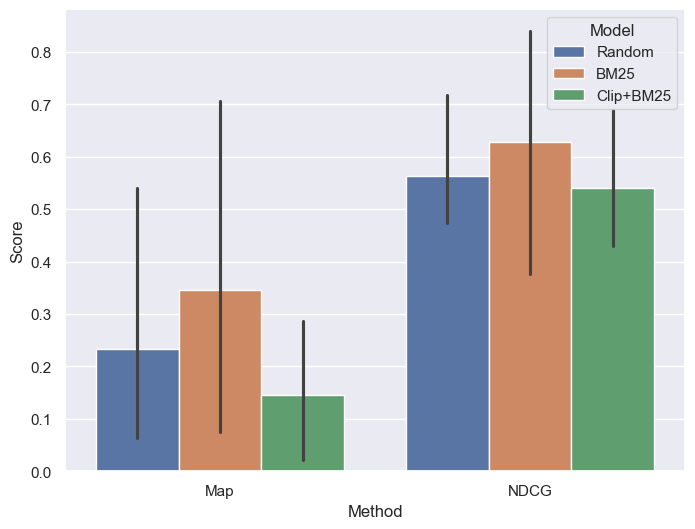

In [553]:
#display data
sns.set(rc={'figure.figsize':(8,6)})
data = pd.DataFrame.from_dict({
    'Random': {
        'Model':'Random',
        'Map':random_map,
        'NDCG':random_ndcg
    },
    'Bm25': {
        'Model':'BM25',
        'Map':bm25_map,
        'NDCG':bm25_ndcg
    },
    'Novel': {
        'Model':'Clip+BM25',
        'Map':novel_map,
        'NDCG':novel_ndcg
    }
},orient='index')
data= pd.melt(data,id_vars=['Model'],value_vars=['Map','NDCG']).explode('value')
print(data)
data=data.rename(columns = {'Model':'Model','variable':"Method",'value':"Score"})
sns.barplot(data,x='Method',y='Score',hue='Model')